In [33]:
from functools import partial
from io import BytesIO
from itertools import islice
import json
import os
import math
import subprocess

from IPython import display
import ipywidgets as widgets
from imageio import imwrite
from ipywidgets import interact
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline
from scipy.io import wavfile
from scipy.signal import get_window
from tqdm import tqdm_notebook

![Both Kinds!](img/both_kinds.png)

# Fast Fourier Transforms

[![Think DSP](http://greenteapress.com/wp/wp-content/uploads/2016/01/think_dsp_cover-229x300.jpg)](http://greenteapress.com/wp/think-dsp/)

In [2]:
def pulse_wave(period, width, N, samples=128):
    pw = width / period
    wave = np.zeros((N+1, samples))
    t = 2.0*np.pi * np.linspace(0.0, 2*np.pi, samples) / period
    for i in range(N-1):
        n = i+1
        wave[i,:] = 2.0/(n*np.pi) * np.sin(np.pi*n*pw) * np.cos(n*t)
    wave[N-1,:] = pw + wave[0:N-1,:].sum(axis=0)
    return wave

def plot_pulse_wave(period, pulse_width, harmonics):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 6)
    width = pulse_width * period
    t = np.linspace(0.0, 2*np.pi, 512)
    wave = pulse_wave(period, width, harmonics, 512)
    for i in range(harmonics-1):
        plt.plot(t, wave[i], color='blue')
    plt.plot(t, wave[harmonics-1], color='green', linewidth=2)

# [Pulse Waves](https://en.wikipedia.org/wiki/Pulse_wave)

$$\Large{\textrm{At time t for period T and duty-cycle $\tau$:}
\\f(t) = \frac{\tau}{T} + \sum_{n=1}^{\infty}\frac{2}{n\pi}sin\left(\frac{\pi n\tau}{T}\right)
cos\left(\frac{2\pi n t}{T} \right)}$$


In [3]:
interact(plot_pulse_wave,
    period = widgets.FloatSlider(min=0.5, max=6.0, value=3.0, step=0.5, description='period'),
    pulse_width = widgets.FloatSlider(min=0.1, max=0.99, value=0.5, step=0.1, description='duty-cycle'),
    harmonics = widgets.IntSlider(min=1, max=50, value=8, step=1, description='harmonics'))

interactive(children=(FloatSlider(value=3.0, description='period', max=6.0, min=0.5, step=0.5), FloatSlider(va…

<function __main__.plot_pulse_wave(period, pulse_width, harmonics)>

# [The Gauss Map](https://en.wikipedia.org/wiki/Gauss_iterated_map)
$$\Huge{x_{n+1} = e^{(-\alpha x_{n}^2)}+\beta}$$

In [4]:
def gauss_map(x,alpha,beta):
    while True:
        yield x
        x = math.exp(-alpha*x*x) + beta
        
def gauss_hist(beta,alpha,n,count,skip):
    gm = gauss_map(0.01,alpha,beta)
    hist = np.histogram(list(islice(gm,skip,skip+count)),n,(-1.5,1.5))[0]
    scale = 1.0 / np.max(hist)
    return hist * scale

def plot_gauss_hist(alpha,beta):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 6)
    plt.plot(gauss_hist(beta, alpha, 720, 512, 4096), color='green')
    plt.show()

In [5]:
interact(plot_gauss_hist, alpha=widgets.FloatSlider(min=1.0,max=9.75, value=4.0, step=0.5, description=r'\(\Large{\alpha}\)'),
    beta=widgets.FloatSlider(min=-1.0,max=1.0, value=-0.5, step=0.05, description=r'\(\Large{\beta}\)'))

interactive(children=(FloatSlider(value=4.0, description='\\(\\Large{\\alpha}\\)', max=9.75, min=1.0, step=0.5…

<function __main__.plot_gauss_hist(alpha, beta)>

In [6]:
def gauss_image(alpha, beta_min, beta_max, width, height):
    img = np.zeros(shape=(height, width,3))
    gh = partial(gauss_hist, alpha=alpha, n=height, count=512, skip=4096)
    img[:,:,1] = np.array(list(map(gh, np.linspace(beta_min, beta_max, width)))).T
    img = 255 * img / img.max()
    return img.astype(np.uint8)

def plot_gauss_image(alpha):
    im_bytes = BytesIO()
    imwrite(im_bytes, gauss_image(alpha, -1.0, 1.0, 600, 480), format='png')
    return display.display(display.Image(data=im_bytes.getvalue()))

def segment(hist, n, win):
    return np.multiply(np.real(np.fft.irfft(hist, n=n)), win)

In [7]:
interact(plot_gauss_image, alpha=widgets.FloatSlider(min=1.0,max=9.75, value=5.0, step=0.5, description=r'\(\Large{\alpha}\)'))

interactive(children=(FloatSlider(value=5.0, description='\\(\\Large{\\alpha}\\)', max=9.75, min=1.0, step=0.5…

<function __main__.plot_gauss_image(alpha)>

Text(0, 0.5, 'windowed signal')

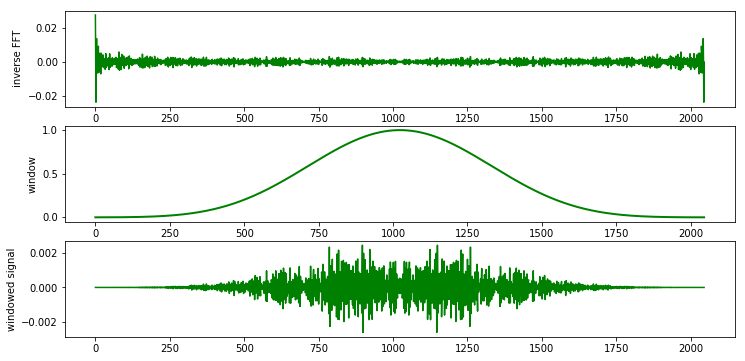

In [8]:
# Example of a windowed IFFT.
%matplotlib inline
N = 1024
window = get_window('blackmanharris',2*(N-1))
fig, axs = plt.subplots(3, 1)
fig.set_size_inches(12, 6)
axs[0].plot(np.real(np.fft.irfft(gauss_hist(-0.6, 9.0, 1024, 512, 409), n=2046)), color='green')
axs[0].set_ylabel('inverse FFT')
axs[1].plot(window, color='green', linewidth=2)
axs[1].set_ylabel('window')
axs[2].plot(segment(gauss_hist(-0.6,9.0,1024,512,409),2046,window), color='green')
axs[2].set_ylabel('windowed signal')

![the first thing to do would be to consider time as offically ended](img/time_officially_ended.png)

In [9]:
def scan(alpha_min,alpha_max,alpha_count,beta_min,beta_max,beta_count):
    d_alpha = (alpha_max - alpha_min) / alpha_count
    d_beta = (beta_max - beta_min) / beta_count
    beta = beta_min
    for i in range(alpha_count):
        alpha = alpha_min + d_alpha * i
        if i % 2 == 1:
            db = -d_beta
        else:
            db = d_beta
        for j in range(beta_count):
            yield(alpha, beta)
            beta += db

            
def frame_count(dur, N, H, bias, rate=44100):
    frames = dur * rate
    segments = int(frames / H)
    alpha_count = int(bias * np.sqrt(segments))
    beta_count = int(segments / alpha_count)
    segments = alpha_count * beta_count
    frames = 2 * (N-1) + segments * H
    return frames, alpha_count, beta_count


def build_frames(dur, N, n, H, bias, alpha_min=1.0, alpha_max=9.75, beta_min=-0.95, beta_max=0.5, rate=44100):
    pan_range = np.arange(N)
    frames, alpha_count, beta_count = frame_count(dur,n,H,bias,rate)
    pan = np.zeros(alpha_count * beta_count)
    output = np.zeros(frames,dtype=np.float32)
    window = get_window('blackmanharris',n)
    hist_count = 4 * N
    with tqdm_notebook(range(alpha_count*beta_count), desc='building audio', leave=True) as bar:
        for i, pars in enumerate(scan(alpha_min ,alpha_max, alpha_count, beta_min , beta_max, beta_count)):
            alpha, beta = pars
            hist = gauss_hist(beta,alpha,N,hist_count,N)
            pan[i] = np.average(pan_range, weights=hist) / N
            seg = segment(hist,n,window)
            start = i * H
            end = start + n
            output[start:end] += seg
            bar.update(1)
    return output, pan


In [10]:
def dump_mono(data,fname,rate=44100):
    scale = 32767.0 / np.max(data) 
    buff = scale * data
    wavfile.write(fname, rate, buff.astype(np.int16))
    
def dump_stereo(data, pan, H, depth, fname, reverse=True, rate=44100):
    scale = 32767.0 / np.max(data)
    floor = 1.0 - depth
    f = UnivariateSpline(np.arange(0,len(data),H)[0:len(pan)], pan)
    pan_interp = depth * f(np.arange(len(data)))
    output = np.zeros((len(data),2))
    output[:,0] = scale * (floor + pan_interp) * data
    if reverse:
        output[::-1,1] = scale * (1.0 - pan_interp) * data
    else:
        output[:,1] = scale * (1.0 - pan_interp) * data   
    wavfile.write(fname, rate, output.astype(np.int16))

In [11]:
def write_frames(path, prefix, frames, alpha_min=1.0, alpha_max=9.75, beta_min=-0.95, beta_max=0.5,
    width=1280, height=720):
    if not os.path.exists(path):
        os.makedirs(path)
    d_alpha = (alpha_max - alpha_min) / frames
    for i in tqdm_notebook(range(frames), desc='building video'):
        alpha = alpha_min + i * d_alpha
        fname = path + '/' + prefix + ('000000'+str(i))[-6:] + '.png'
        img = gauss_image(alpha, beta_min, beta_max, width, height)
        imwrite(fname, img, format='png')



In [12]:
name_box = widgets.Text(value='gauss_map', placeholder='enter a filename', description='filename')
dur_slider = widgets.IntSlider(min=10, max=600, value=240, step=5, description='duration (s)')
sample_slider = widgets.IntSlider(min=8, max=14, value=10, step=1, description='samples')
fft_slider = widgets.IntSlider(min=8, max=20, value=16, step=1, description='FFT size')
hop_slider = widgets.IntSlider(min=7, max=14, value=11, step=1, description='hop size')
bias_slider = widgets.FloatSlider(min=0.1, max=1.5, value=0.25, step=1, description='bias')
build_video = widgets.RadioButtons(options=['off', 'on'], value='off', description='build video')
build_button = widgets.Button(description='Build')

def build_gaussmap(b):
    fname = name_box.value
    dur = dur_slider.value
    N = 2**sample_slider.value
    n = 2**fft_slider.value
    H = 2**hop_slider.value
    bias = bias_slider.value
    
    if build_video.value == 'on':
        video = True
        rate = 48000
    else:
        video = False
        rate = 44100
    
    output, pan = build_frames(dur, N, n+N, H, bias, rate=rate)
    
    for direc in ('audio', 'frames', 'video'):
        if not os.path.exists(direc):
            os.makedirs(direc)
    audio_file = '/'.join(['audio', '{}.wav'.format(fname)])

    output = dump_stereo(output, pan, H, 0.5, audio_file, reverse=True, rate=rate)
    
    if video:
        frames = 24 * dur
        frame_path = '/'.join(['frames', fname])
        write_frames(frame_path, 'gauss_', frames)
        video_file = '/'.join(['video', '{}.mp4'.format(fname)])
        
        args = ['ffmpeg', '-i', '{}/gauss_%06d.png'.format(frame_path), '-i',
            audio_file, '-c:v', 'libx264', '-acodec', 'libmp3lame', '-r', '24',
            '-pix_fmt', 'yuv420p', video_file]
        
        subprocess.run(args)

    display.display(display.Audio(filename=audio_file))
    
    if video:
        display.display(widgets.Video.from_file(video_file))

build_button.on_click(build_gaussmap)

In [13]:
for wdgt in (name_box, dur_slider, sample_slider, fft_slider, hop_slider, bias_slider, build_video,
    build_button):
    display.display(wdgt)

Text(value='gauss_map', description='filename', placeholder='enter a filename')

IntSlider(value=240, description='duration (s)', max=600, min=10, step=5)

IntSlider(value=10, description='samples', max=14, min=8)

IntSlider(value=16, description='FFT size', max=20, min=8)

IntSlider(value=11, description='hop size', max=14, min=7)

FloatSlider(value=0.25, description='bias', max=1.5, min=0.1, step=1.0)

RadioButtons(description='build video', options=('off', 'on'), value='off')

Button(description='Build', style=ButtonStyle())

In [14]:
class Oliva(object):
    def __init__(self,width=640, skip=12, act_diff=0.015, act_decay=0.1,
        act_prod=0.1, sat=0.25, in_diff=0.0, in_decay=0.014, in_mm=0.1,
        h_decay=0.1, hormone=0.5):
         
        self.width = width
        self.cells = np.zeros((2,2,self.width))
        
        self.skip = skip
        
        self.act_diff = act_diff
        self.act_decay = act_decay
        self.act_prod = act_prod
        self.sat = sat
         
        self.in_diff = in_diff
        self.in_decay = in_decay
        self.in_mm = in_mm
        self.h_decay = h_decay
        self.h_fac = 1-self.h_decay
        self.hormone = hormone
        
        self.tick = False
         
        self.cells[0,1,:] = 0.1
         
        self.fluct = self.act_decay * (0.96 +
            0.08 *np.random.random(self.width))
            
        seeds = np.random.choice(np.arange(self.width),30,replace=False)
        self.cells[0,0,seeds] = 1.0
        
        self.act_diff_const = 1.0 - self.act_decay -2*self.act_diff
        self.in_diff_const = 1.0 - self.in_decay -2*self.in_diff


    def step(self):
        if self.tick:
            old = 1
            new = 0
        else:
            old = 0
            new = 1
        
        l_bound = np.copy(self.cells[old,:,0])
        r_bound = np.copy(self.cells[old,:,-1])
                
        act_sq = np.square(self.cells[old,0,:])
        auto_cat = self.fluct * act_sq / (1 + self.sat * act_sq)
        
        left_cells = np.roll(self.cells[old,:,:],-1,axis=1)
        right_cells = np.roll(self.cells[old,:,:],1,axis=1)

        left_cells[:,0] = l_bound
        right_cells[:,-1] = r_bound
                
        self.cells[new,0,:] = self.cells[old,0,:] * self.act_diff_const + self.act_diff * (left_cells[0,:] + right_cells[0,:]) + auto_cat / (self.in_mm + self.cells[old,1,:])
            
        self.cells[new,1,:] = self.cells[old,1,:] * self.in_diff_const + self.in_diff * (left_cells[1,:] + right_cells[1,:]) + auto_cat
            
        hormone_prod = (self.cells[old,0,:] * self.h_decay).sum()
        
        self.hormone = self.hormone * self.h_fac + hormone_prod / self.width
            
        self.in_diff_const = 1.0 - 2 * self.in_diff - self.in_decay / self.hormone
        
        self.tick = not self.tick
        
        
    def __iter__(self):
        return self
    
    
    def __next__(self):
        self.step()
        if self.tick:
            out = np.copy(self.cells[0,:,:])
        else:
            out = np.copy(self.cells[1,:,:])
        for i in range(self.skip):
            self.step()
        return out

In [15]:
def left_cell(mollusc):
    mollusc.cells[0,:,0] = mollusc.init_conc[:,0]
    
    
def left_right_cell(mollusc):
    mollusc.cells[0,:,0] = mollusc.init_conc[:,0]
    mollusc.cells[0,:,-1] = mollusc.init_conc[:,0]
    
    
def central_cell(mollusc):
    mollusc.cells[0,:,mollusc.width//2] = mollusc.init_conc[:,0]
        
    
initial_conditions = {1:left_cell, 2:left_right_cell,
    3:central_cell}

In [16]:
class Mollusc(object):
    
    def argfilter(self,initial,**kwargs):
        linitial = initial.lower()
        args = filter(lambda k: len(k)==2 and k.lower().startswith(linitial), kwargs.keys())
        return np.array([[kwargs[k] for k in sorted(args)[0:self.num_vars]]]).T


    def __init__(self,width=640,**kwargs):
        self.width = width
        
        self.num_vars = kwargs['kn']
        
        self.diff_coeffs = self.argfilter('d', **kwargs)
        self.decay_rates = self.argfilter('r', **kwargs)
        self.basic_prod = self.argfilter('b', **kwargs)
        self.saturation = self.argfilter('s', **kwargs)
        self.coupling = self.argfilter('c', **kwargs)
        self.init_conc = self.argfilter('a', **kwargs)
        self.gen_conc = self.argfilter('g', **kwargs)

        self.activator_saturation = self.saturation[0]

        self.substrate = np.ones(width)

        self.decay_diff_consts = 1.0 - self.decay_rates - 2 * self.diff_coeffs

        eq_methods = {method:getattr(self, method)
            for method in dir(self) if method.startswith('eq_')}

        self.eq = eq_methods['eq_'+str(kwargs['ke'])]
        
        self.skip = kwargs['kp']
        
        perturb = kwargs.get('kr',2) / 100.0
        fluctuations = 1.0 + perturb * (np.random.random(self.width) - 0.5)    
        self.s = self.decay_rates[0] * fluctuations
    
        self.old = 0
        self.new = 1
        
        self.condition_pars = [kwargs.get('k'+str(i),0) for i in range(1,5)]
        
        self.cells = np.zeros((2,self.num_vars,self.width))
        self.cells[0,:,:] = self.gen_conc

        try:
            initializer = initial_conditions[kwargs['ki']]
        except:
            initializer = initial_conditions[3]
        initializer(self)
        

    def step(self):
        
        old_cells = self.cells[self.old,:,:]
        new_cells = self.cells[self.new,:,:]

        l_bound = np.copy(self.cells[self.old,:,0])
        r_bound = np.copy(self.cells[self.old,:,-1])

        left_cells = np.roll(old_cells,-1,axis=1)
        right_cells = np.roll(old_cells,1,axis=1)

        left_cells[:,0] = l_bound
        right_cells[:,-1] = r_bound

        decay = old_cells * self.decay_diff_consts + self.diff_coeffs * (left_cells + right_cells)   
        
        a_sq = np.square(old_cells[0,:])
        
        self.eq(old_cells,new_cells,decay,a_sq)
        
        self.old, self.new = self.new, self.old

        
    def stabilize(self,*args):
        substances = np.array(sorted(args))
        to_zero = self.cells[self.new,substances,:] < 0.0
        self.cells[self.new,substances,:][to_zero] = 0.0


    def __iter__(self):
        return self
    
    
    def __next__(self):
        for i in range(self.skip):
            self.step()
        return np.copy(self.cells[self.new,:,:])
    
    
    def eq_21(self,old_cells,new_cells,decay,a_sq):
        """- activator - inhibitor mechanism: B is inhibitor"""
        a_sq = np.square(old_cells[0])
        new_cells[0] = decay[0] + self.s * (a_sq / old_cells[1] + self.basic_prod[0])
        new_cells[1] = decay[1] + self.s * a_sq + self.basic_prod[1]

        
    def eq_61(self,old_cells,new_cells,decay,a_sq):
        """Hormone (c) changes lifetime of the inhibitor"""
        aq = self.s * a_sq / (1 + self.activator_saturation * a_sq) + self.basic_prod[0]
        new_cells[0] = decay[0] + aq / (self.saturation[1] + old_cells[1])
        new_cells[1] = decay[1] + aq + self.basic_prod[1]

        
    def eq_711(self,old_cells,new_cells,decay,a_sq):
        aq = self.s * old_cells[1] * (a_sq /
            (1 + self.activator_saturation * a_sq) + self.basic_prod[0])
        new_cells[0] = (decay[0] + aq - self.coupling[4] * old_cells[0] *
            old_cells[4])
        new_cells[1] = decay[1] - aq + self.basic_prod[1]
        e_sq = np.square(old_cells[4])
        eq = self.decay_rates[4] * old_cells[5] * (e_sq /
            (1.0 + self.saturation[4] * e_sq) + self.basic_prod[4])
        new_cells[4] = decay[4] + eq + self.saturation[5] * old_cells[0]
        new_cells[5] = decay[5] - eq + self.basic_prod[5] * old_cells[0] + self.coupling[5] * self.substrate
        self.stabilize(1,5)


In [31]:
def green_image(cells):
    height, width = cells.shape
    img = np.zeros(shape=(height, width,3))
    img[:,:,1] = cells
    img = 255 * img / img.max()
    im_bytes = BytesIO()
    imwrite(im_bytes, img.astype(np.uint8), format='png')
    return display.display(display.Image(data=im_bytes.getvalue()))

def draw_oliva(width=640):
    oliva_porphyria = Oliva(width=width)
    oliva_cells = np.stack(list(islice(oliva_porphyria, 0, width)))
    return green_image(oliva_cells[:,0,:])

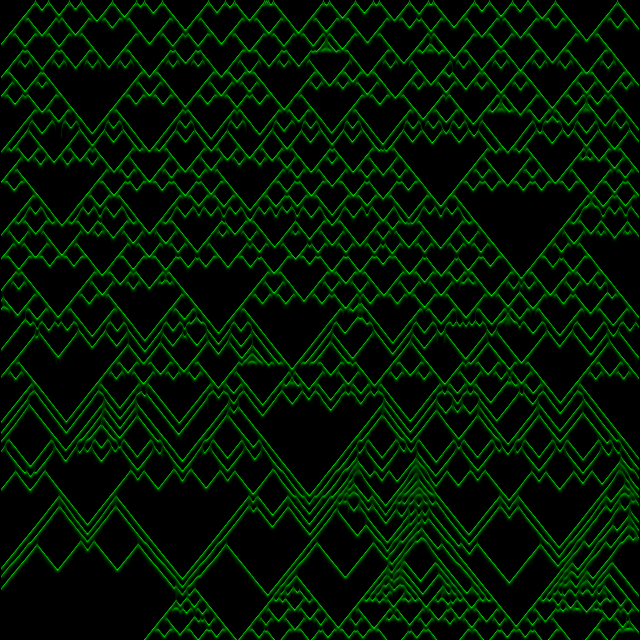

In [32]:
draw_oliva()

In [38]:
with open('sp_pars.json','r') as par_file:
    sp_pars = json.loads(par_file.read())
ext_pars = list(filter(lambda p: p['ke']==711, sp_pars))

conus_nobilis_pars = ext_pars[4]

In [75]:
def draw_conus_nobilis(width=400):
    conus_nobilis = Mollusc(width=width, **conus_nobilis_pars)
    conus_cells = np.stack(list(islice(conus_nobilis, 0, width)))
    img = np.zeros(shape=(width, 2*width, 3))
    left = conus_cells[:,0,:]
    left = (255 * left / left.max())
    right = conus_cells[:,5,:]
    right = 255 * right / right.max()
    img[:,0:width,1] = left
    img[:,width:,1] = right
    im_bytes = BytesIO()
    imwrite(im_bytes, img.astype(np.uint8), format='png')
    return display.display(display.Image(data=im_bytes.getvalue()))

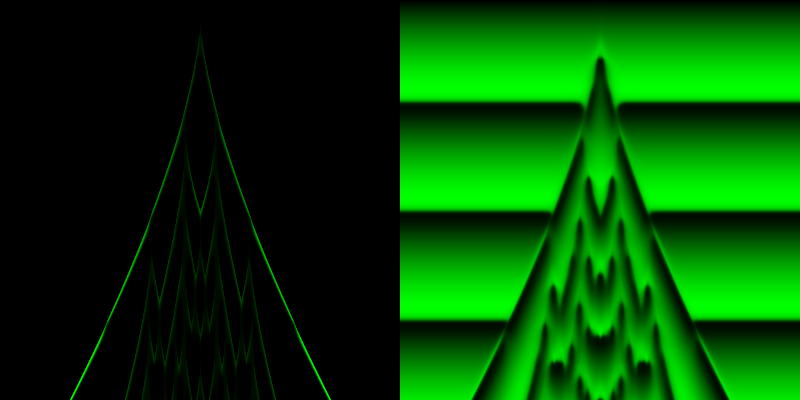

In [76]:
draw_conus_nobilis()